In [10]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import ast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from keras.src.callbacks import EarlyStopping
from matplotlib import pyplot as plt

In [11]:
!cp /content/drive/MyDrive/AI/Data/merged_data.csv /content/

cp: directory /content does not exist


# Chargement des données
Nous allons charger les données à partir du fichier CSV créer avec le modèle Word2Vec et les diviser en ensembles d'entraînement et de test. Nous allons également convertir les phonèmes en listes.

In [12]:
onDrive = False
if onDrive:
    # Path to the CSV file
    csv_file_path = 'merged_data.csv'
else:
    # Path to the CSV file
    csv_file_path = './Data/merged_data.csv'

# Load the DataFrame from the CSV file
df_merged = pd.read_csv(csv_file_path)


# Determine the split index
split_index = int(0.8 * len(df_merged))

# Split into training and testing datasets
train_df = df_merged[:split_index]
test_df = df_merged[split_index:]

print(f"Training set size: {len(train_df)}, Testing set size: {len(test_df)}")

Training set size: 970, Testing set size: 243


In [13]:
def convertir_en_liste(chaine):
    try:
        # Convertit la chaîne en liste en utilisant ast.literal_eval
        return ast.literal_eval(chaine)
    except Exception as e:
        # Gérer les exceptions si la conversion échoue
        print(f"Erreur de conversion : {e}")
        return []


def reduire_pad(liste):
    nouvelle_liste = []
    for elem in liste:
        if elem != "[PAD]" or (nouvelle_liste and nouvelle_liste[-1] != "[PAD]"):
            nouvelle_liste.append(elem)
    return nouvelle_liste


# Appliquer la conversion et la réduction
# Assurez-vous que train_df est une copie indépendante si c'est un sous-ensemble
train_df = train_df.copy()

# Appliquer la conversion et la réduction en utilisant .loc
train_df.loc[:, 'phoneme'] = train_df['phoneme'].apply(lambda x: reduire_pad(convertir_en_liste(x)))

# Afficher les premières lignes de train_df pour vérifier les changements
print(train_df.head())

                                             phoneme language
0  [t, t, h, h, e, y, y, |, |, s, s, s, [PAD], o,...  English
1  [t, t, o, o, |, |, |, c, c, [PAD], e, e, l, l,...  English
2  [t, t, h, h, e, e, |, |, |, |, b, [PAD], o, o,...  English
3  [d, [PAD], o, o, [PAD], n, [PAD], o, u, w, [PA...   French
4  [h, e, e, |, |, |, c, [PAD], m, m, [PAD], o, [...  English


In [14]:
test_df = test_df.copy()

# Appliquer la conversion et la réduction en utilisant .loc
test_df.loc[:, 'phoneme'] = test_df['phoneme'].apply(lambda x: reduire_pad(convertir_en_liste(x)))

# Afficher les premières lignes de train_df pour vérifier les changements
print(test_df.head())

                                               phoneme language
970  [t, t, h, h, e, e, |, |, |, |, p, p, [PAD], a,...  English
971  [t, h, e, e, e, x, [PAD], p, p, e, [PAD], d, [...   French
972  [a, a, [PAD], |, |, y, y, o, o, u, u, |, |, |,...  English
973  [t, t, [PAD], o, o, [PAD], v, [PAD], e, e, s, ...  English
974  [w, h, h, a, t, |, |, d, o, o, e, [PAD], s, s,...  English


# Tokenisation et padding
Dans cette section, nous allons convertir les phonèmes en séquences d'entiers et les rembourrer pour qu'ils aient tous la même longueur.

In [15]:
train_df['language'] = train_df['language'].apply(lambda x: 0 if x == 'French' else 1)
test_df['language'] = test_df['language'].apply(lambda x: 0 if x == 'French' else 1)

# Ensuite, continuez avec la tokenisation et le padding comme avant
phoneme_tokenizer = Tokenizer(char_level=False)
phoneme_tokenizer.fit_on_texts(train_df['phoneme'])
X_train = phoneme_tokenizer.texts_to_sequences(train_df['phoneme'])
X_train = pad_sequences(X_train, padding='post')

X_test = phoneme_tokenizer.texts_to_sequences(test_df['phoneme'])
X_test = pad_sequences(X_test, padding='post', maxlen=X_train.shape[1])

# Encode the language labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['language'])
y_test = label_encoder.transform(test_df['language'])

In [16]:
print(test_df.head())

                                               phoneme  language
970  [t, t, h, h, e, e, |, |, |, |, p, p, [PAD], a,...         1
971  [t, h, e, e, e, x, [PAD], p, p, e, [PAD], d, [...         0
972  [a, a, [PAD], |, |, y, y, o, o, u, u, |, |, |,...         1
973  [t, t, [PAD], o, o, [PAD], v, [PAD], e, e, s, ...         1
974  [w, h, h, a, t, |, |, d, o, o, e, [PAD], s, s,...         1


In [17]:
print(train_df.head())

                                             phoneme  language
0  [t, t, h, h, e, y, y, |, |, s, s, s, [PAD], o,...         1
1  [t, t, o, o, |, |, |, c, c, [PAD], e, e, l, l,...         1
2  [t, t, h, h, e, e, |, |, |, |, b, [PAD], o, o,...         1
3  [d, [PAD], o, o, [PAD], n, [PAD], o, u, w, [PA...         0
4  [h, e, e, |, |, |, c, [PAD], m, m, [PAD], o, [...         1


# Création du modèle
Nous allons maintenant créer le modèle RNN. Nous utiliserons un modèle LSTM bidirectionnel.

In [21]:
# Parameters for the model
vocab_size = len(phoneme_tokenizer.word_index) + 1  # Vocabulary size
embed_dim = 1024  # Dimension of the embedding vectors
max_length = X_train.shape[1]  # Maximum length of the input sequences
output_dim = len(label_encoder.classes_)  # Number of unique output classes

# Define the RNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_length),
    LSTM(units=2048, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
    Dense(output_dim, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 640, 1024)         30720     
                                                                 
 lstm_4 (LSTM)               (None, 640, 2048)         25174016  
                                                                 
 lstm_5 (LSTM)               (None, 128)               1114624   
                                                                 
 dense_2 (Dense)             (None, 2)                 258       
                                                                 
Total params: 26319618 (100.40 MB)
Trainable params: 26319618 (100.40 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Entraînement du modèle et évaluation
Nous allons maintenant entraîner le modèle et évaluer ses performances.

Epoch 1/150
31/31 [==============================] - 846s 27s/step - loss: 0.7451 - accuracy: 0.5155 - val_loss: 0.6972 - val_accuracy: 0.4733
Epoch 2/150
31/31 [==============================] - 850s 27s/step - loss: 0.7021 - accuracy: 0.5093 - val_loss: 0.6976 - val_accuracy: 0.5226
Epoch 3/150
31/31 [==============================] - 852s 28s/step - loss: 0.6942 - accuracy: 0.5309 - val_loss: 0.6917 - val_accuracy: 0.5267
Epoch 4/150
31/31 [==============================] - 847s 27s/step - loss: 0.7148 - accuracy: 0.4887 - val_loss: 0.7225 - val_accuracy: 0.4733
Epoch 5/150
31/31 [==============================] - 855s 28s/step - loss: 0.6983 - accuracy: 0.4948 - val_loss: 0.7034 - val_accuracy: 0.4733
Epoch 6/150
31/31 [==============================] - 821s 26s/step - loss: 0.6930 - accuracy: 0.5227 - val_loss: 0.6939 - val_accuracy: 0.4733
Epoch 7/150
31/31 [==============================] - 837s 27s/step - loss: 0.6930 - accuracy: 0.5227 - val_loss: 0.6964 - val_accuracy: 0.4733

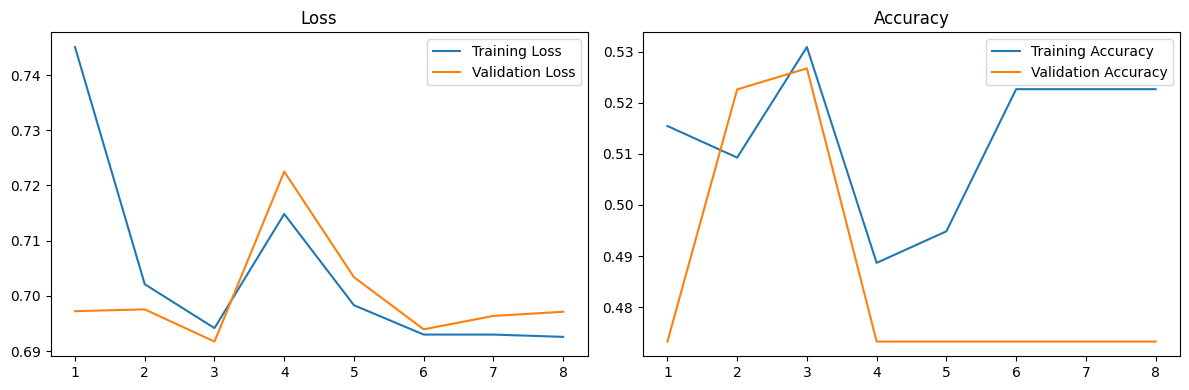

In [22]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=150, validation_data=(X_test, y_test), batch_size=32,
                    callbacks=[early_stopping])

# Préparation de la gamme des époques pour le tracé.
epochs_range = range(1, len(history.history['accuracy']) + 1)

# Configuration de la taille et du layout des graphiques.
plt.figure(figsize=(12, 4))

# Tracé de la perte d'entraînement et de validation.
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

# Tracé de la précision d'entraînement et de validation.
plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()

# Affichage des graphiques.
plt.tight_layout()
plt.show()

In [23]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

8/8 [==============================] - 42s 5s/step - loss: 0.6917 - accuracy: 0.5267
Test Accuracy: 0.5267489552497864
